## 1. Imports

In [439]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
from prettytable import PrettyTable

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier

import shap
import optuna
from optuna import Trial
from optuna import create_study
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from utils.eda import summary

## 2. Notebook Settings

In [440]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

## 3. Config

In [441]:
class CFG:
    use_org = True
    use_pseudo = False

## 3. Data Load

In [442]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
submission_df = pd.read_csv('sample_submission.csv')

## 4. Add Original Data

In [443]:
if CFG.use_org:
    train_df.drop(columns=["id"],inplace=True)

    original = pd.read_csv('original_train.csv')
    original.drop(columns=['RowNumber'],inplace=True)

    train_df = pd.concat([train_df, original], axis=0)
    train_df.dropna(inplace=True)

## 5. EDA

In [444]:
def summary(df: pd.DataFrame) -> pd.DataFrame:
    '''Returns a summary table with stats, missing values etc.'''
    print(f'data shape: {df.shape}')
    duplicates = df[df.duplicated()]
    print(f"Number of duplicates found and removed: {len(duplicates)}")
    df = df.drop_duplicates()
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    
    return summ

In [445]:
summary_df = summary(test_df)
summary_df

data shape: (110023, 13)
Number of duplicates found and removed: 0


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
id,int64,0,0.00,110023,"165,034.00","275,056.00","220,045.00","31,761.05"
CustomerId,int64,0,0.00,19698,"15,565,701.00","15,815,690.00","15,692,096.61","71,684.99"
Surname,object,0,0.00,2708,NaN,NaN,NaN,NaN
CreditScore,int64,0,0.00,454,350.00,850.00,656.53,80.32
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN
Age,float64,0,0.00,74,18.00,92.00,38.12,8.86
Tenure,int64,0,0.00,11,0.00,10.00,5.00,2.81
Balance,float64,0,0.00,22513,0.00,"250,898.09","55,333.61","62,788.52"
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.54


In [446]:
summary_df = summary(train_df)
summary_df

data shape: (175032, 13)
Number of duplicates found and removed: 2


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
CustomerId,int64,0,0.00,23421,"15,565,701.00","15,815,690.00","15,691,944.51","71,428.44"
Surname,object,0,0.00,2932,NaN,NaN,NaN,NaN
CreditScore,int64,0,0.00,460,350.00,850.00,656.11,81.15
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN
Age,float64,0,0.00,73,18.00,92.00,38.17,8.97
Tenure,int64,0,0.00,11,0.00,10.00,5.02,2.81
Balance,float64,0,0.00,30239,0.00,"250,898.09","56,677.30","62,982.32"
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.55
HasCrCard,float64,0,0.00,2,0.00,1.00,0.75,0.43


### 5.1. Numerical/Categorical Data Split

In [447]:
cat_cols = [column for column in train_df.columns if train_df[column].dtype == 'object']
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

num_cols.remove('Exited')
num_cols.remove('CustomerId')
cat_cols.remove('Surname')

num_cols.remove('IsActiveMember')
cat_cols.append('IsActiveMember')

num_cols.remove('Tenure')
cat_cols.append('Tenure')

num_cols.remove('NumOfProducts')
cat_cols.append('NumOfProducts')

num_cols.remove('HasCrCard')
cat_cols.append('HasCrCard')

target_col = 'Exited'

train_df['HasCrCard'].astype('category')
train_df['IsActiveMember'].astype('category');

In [448]:
print(f'Category Columns: {cat_cols}')
print(f'Numerical Columns: {num_cols}')
print(f'Target Column: {target_col}')

Category Columns: ['Geography', 'Gender', 'IsActiveMember', 'Tenure', 'NumOfProducts', 'HasCrCard']
Numerical Columns: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Target Column: Exited


### 5.2 Target Distribution
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

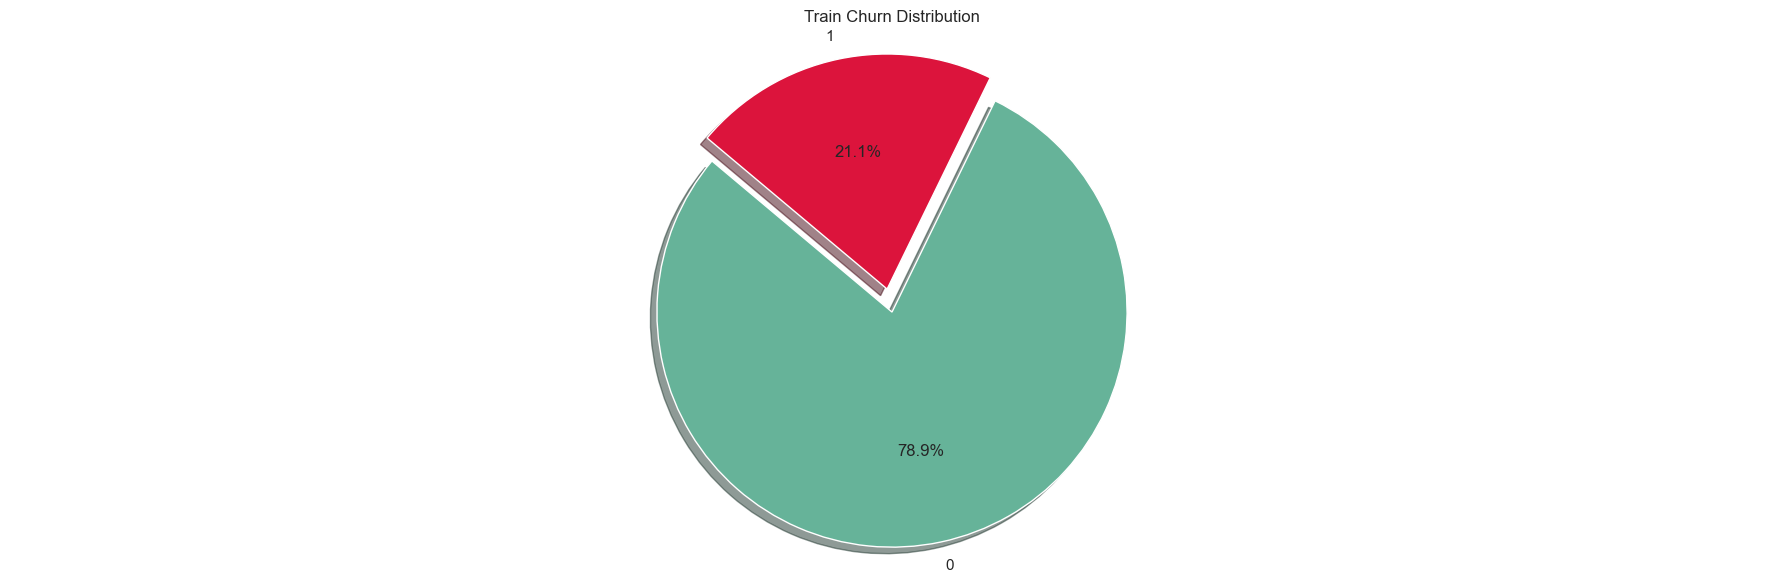

In [449]:
def plot_pie_chart(data, title, ax):
    data_counts = data[target_col].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.4, 0.7, 0.6), 'crimson']  
    explode = (0.1, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 1, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train_df, "Train Churn Distribution", axes)

plt.tight_layout()
plt.show()

### 5.3 Numerical Data Analysis 
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

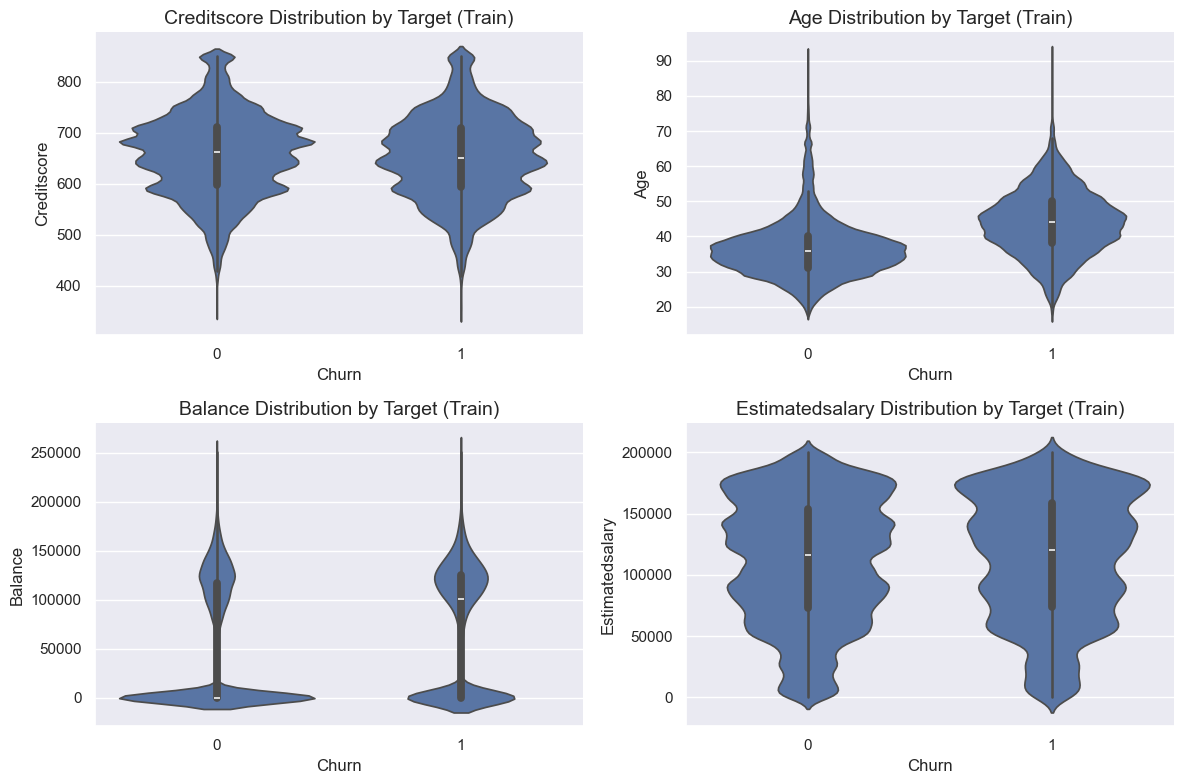

In [450]:
n_rows = len(num_cols)
n_cols = 2
fig, axs = plt.subplots(n_rows // n_cols, n_cols, figsize=(12, 4 * (n_rows // n_cols)))
sns.set_palette("Set3")

for i, col in enumerate(num_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols

    sns.violinplot(x=target_col, y=col, data=train_df, ax=axs[row_idx, col_idx])
    axs[row_idx, col_idx].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[row_idx, col_idx].set_xlabel('Churn', fontsize=12)
    axs[row_idx, col_idx].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

### 5.4 EDA Categorical Data Analysis
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

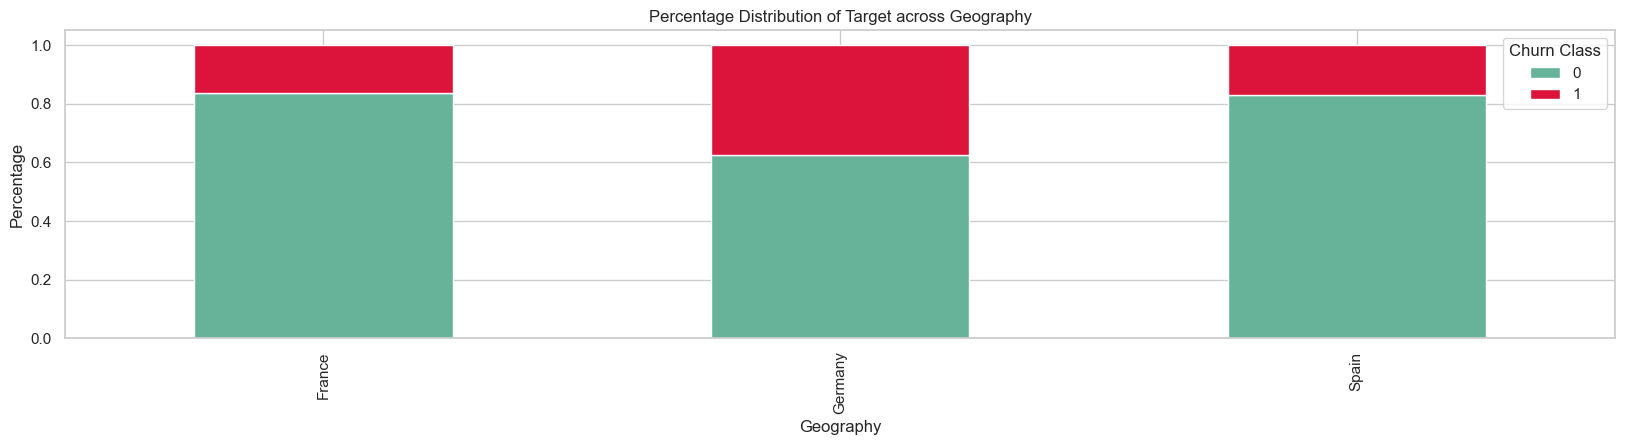

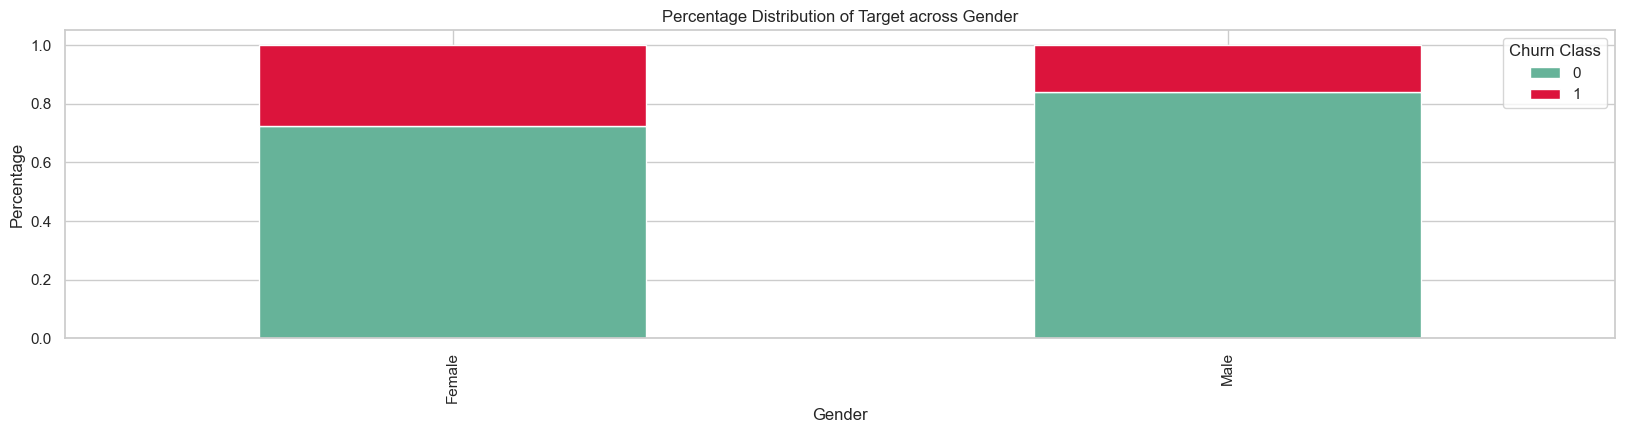

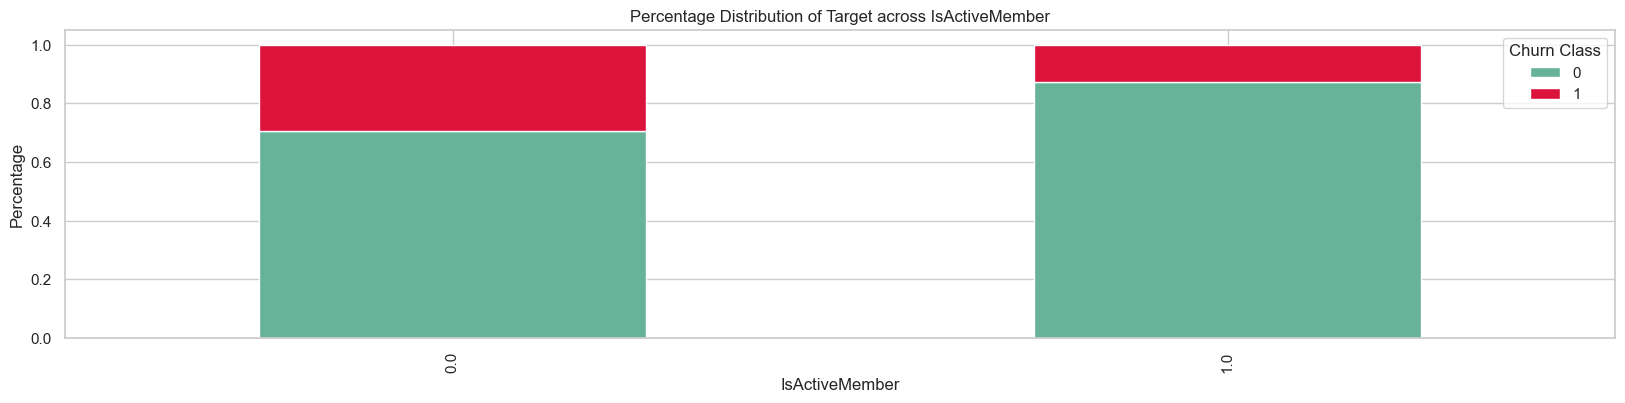

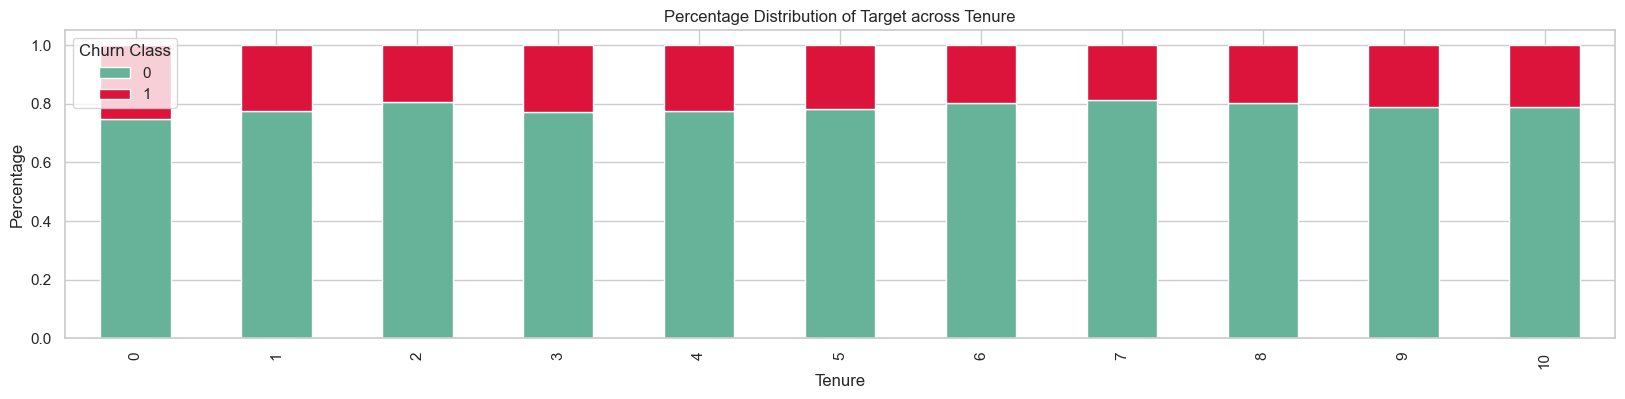

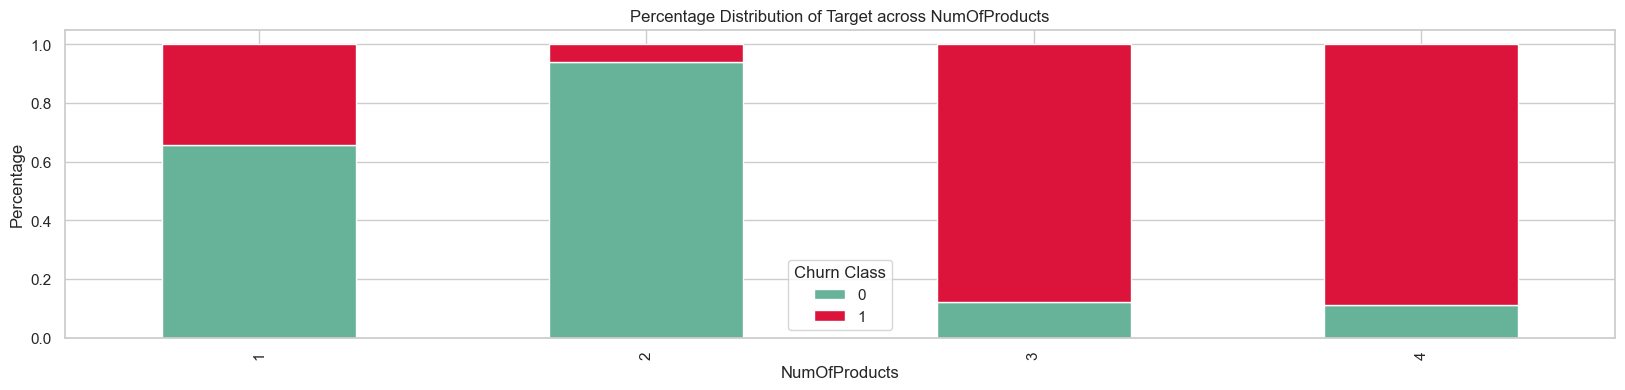

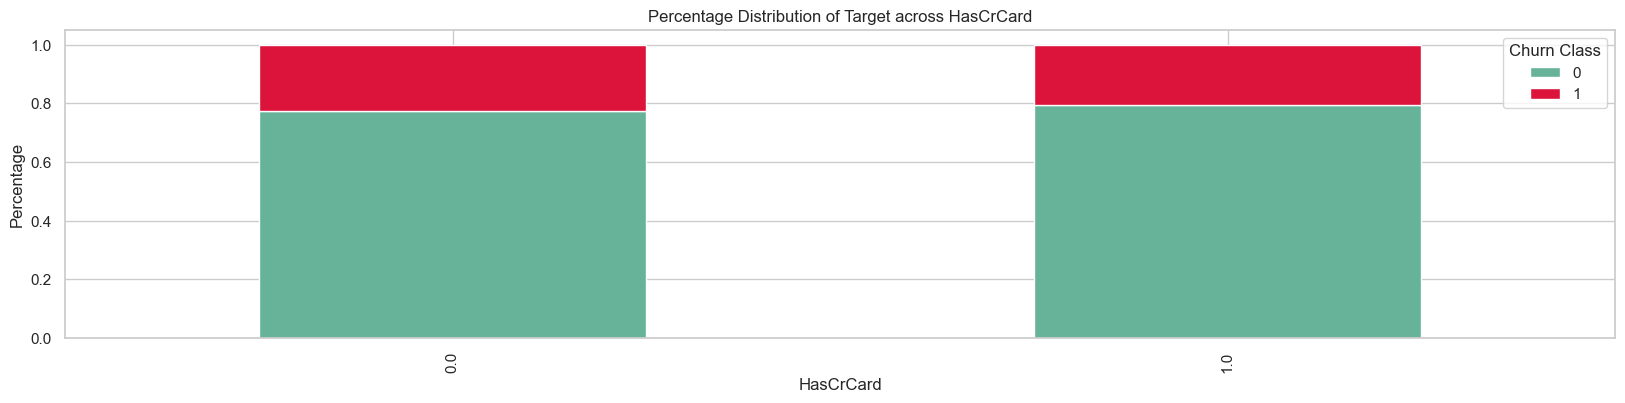

In [451]:
custom_palette =(0.4, 0.7, 0.6), 'crimson'
for col in cat_cols:
    contingency_table = pd.crosstab(train_df[col], train_df[target_col], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Churn Class")
    plt.show()

## 6. Feature Engineering
### 6.1 Arithmetical Operations betweeen columns

In [452]:
class ArithmeticFeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols):
        self.num_cols = num_cols
        self.new_num_cols = []

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # Perform the arithmetic operations without creating redundant features
        for i, col1 in enumerate(self.num_cols):
            for col2 in self.num_cols[i+1:]:  # Start from i+1 to avoid redundancy
                X[f'{col1}+{col2}'] = X[col1] + X[col2]
                X[f'{col1}*{col2}'] = X[col1] * X[col2]
                self.new_num_cols.extend([f'{col1}+{col2}', f'{col1}*{col2}'])
        return X

    def get_feature_names_out(self):
        # Return the new column names after transformation
        return self.num_cols + self.new_num_cols

arithmetic_combiner = ArithmeticFeatureCombiner(num_cols)

### 6.2 Concat

In [453]:
class StringConcatenator(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2):
        self.col1 = col1
        self.col2 = col2
        self.new_col_name = col1 + '_' + col2

    def fit(self, X, y=None):
        # No fitting needed for concatenation
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.new_col_name] = X_copy[self.col1].astype(str) + X_copy[self.col2].astype(str)
        return X_copy
    
geo_gender = StringConcatenator('Geography', 'Gender')

### 6.2 Binning

In [454]:
class Binning(BaseEstimator, TransformerMixin):
    def __init__(self, col, n_bins):
        self.n_bins = n_bins
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X[self.col], self.n_bins, labels=False, duplicates='drop')
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}{self.col}',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
    
age_binner = Binning('Age', 5)
balance_binner = Binning('Balance',5)
salary_binner = Binning('EstimatedSalary',5)
credit_score_binner = Binning('CreditScore',5)

### 6.3 Aggregations

In [455]:
class GroupByMergeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.agg_col = agg_col
        self.agg_func = agg_func

    def fit(self, X, y=None):
        # Create the aggregated DataFrame
        self.agg_df_ = X.groupby(by=self.group_col).agg({self.agg_col: self.agg_func}).reset_index().rename(columns={self.agg_col: f'{self.agg_col}_agg'})
        return self

    def transform(self, X):
        # Merge the original DataFrame with the aggregated DataFrame
        merged = pd.merge(X, self.agg_df_, on=self.group_col, how='left')
        merged[f'{self.agg_col}_agg'] = merged[f'{self.agg_col}_agg'].fillna(0)
        return merged
    
agg_balance_sum = GroupByMergeTransformer(group_col='CustomerId', agg_col='Balance', agg_func='sum')

### 6.4 Zero Detection

In [456]:
class ZeroTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.new_column_name = column+'_is_zero'

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # Create a new column with the transformed values
        X[self.new_column_name] = X[self.column].apply(lambda x: 1 if x == 0 else 0)
        return X
    
# Create an instance of your custom transformer
balance_zero_transformer = ZeroTransformer(column='Balance')

### 6.5 Clustering

In [457]:
class PCAClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_components, n_clusters):
        self.columns = columns
        self.n_components = n_components
        self.n_clusters = n_clusters
        self.pca = PCA(n_components=self.n_components)
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)

    def fit(self, X, y=None):
        X_subset = X[self.columns]
        self.pca.fit(X_subset)
        X_pca = self.pca.transform(X_subset)
        self.kmeans.fit(X_pca)
        return self

    def transform(self, X):
        X_subset = X[self.columns]
        X_pca = self.pca.transform(X_subset)

        # Shift PCA components to be non-negative
        min_values = np.min(X_pca, axis=0)
        shift_values = np.abs(min_values) * (min_values < 0)
        X_pca += shift_values

        clusters = self.kmeans.predict(X_pca)
        X_transformed = X.copy()
        X_transformed['Cluster'] = clusters

        for i in range(self.n_components):
            X_transformed[f'PCA_{i}'] = X_pca[:, i]

        return X_transformed
    
pca_clustering_transformer = PCAClusteringTransformer(
    columns=["CustomerId","EstimatedSalary","Balance"], n_components=2, n_clusters=3)

### 6.6 Encoding

In [458]:
encoding = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
     make_column_selector(dtype_include=object))
], remainder='passthrough').set_output(transform='pandas')

In [459]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = None

    def fit(self, X, y=None):
        self.encoders = {}
        for column in X.columns:
            le = LabelEncoder()
            le.fit(X[column])
            self.encoders[column] = le
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in X.columns:
            le = self.encoders[column]
            X_transformed[column] = le.transform(X[column])
        return X_transformed


label_encoding = CustomLabelEncoder()

### 6.7 Scaling

In [460]:
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.numerical_columns = []

    def fit(self, X, y=None):
        # Identify numerical columns
        self.numerical_columns = X.select_dtypes(include=[np.number]).columns
        self.scaler.fit(X[self.numerical_columns])
        return self

    def transform(self, X):
        # Apply MinMaxScaler only to numerical columns
        X_scaled = X.copy()
        X_scaled[self.numerical_columns] = self.scaler.transform(X[self.numerical_columns])
        return X_scaled


scaler = CustomMinMaxScaler()

## 7. Feature Selection

In [461]:
class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=12):
        self.k = k
        self.selector = SelectKBest(mutual_info_classif, k=self.k)

    def fit(self, X, y=None):
        # Ensure that X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input X must be a pandas DataFrame")
        
        # Fit the selector to the data
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        # Transform the data and return a DataFrame
        X_transformed = self.selector.transform(X)
        selected_features = X.columns[self.selector.get_support()]
        return pd.DataFrame(X_transformed, columns=selected_features)
        

feature_selector = CustomFeatureSelector()

### 7.1 Correlation table 
https://www.kaggle.com/code/ashishkumarak/binary-classification-smoker-or-not-eda-xgboost

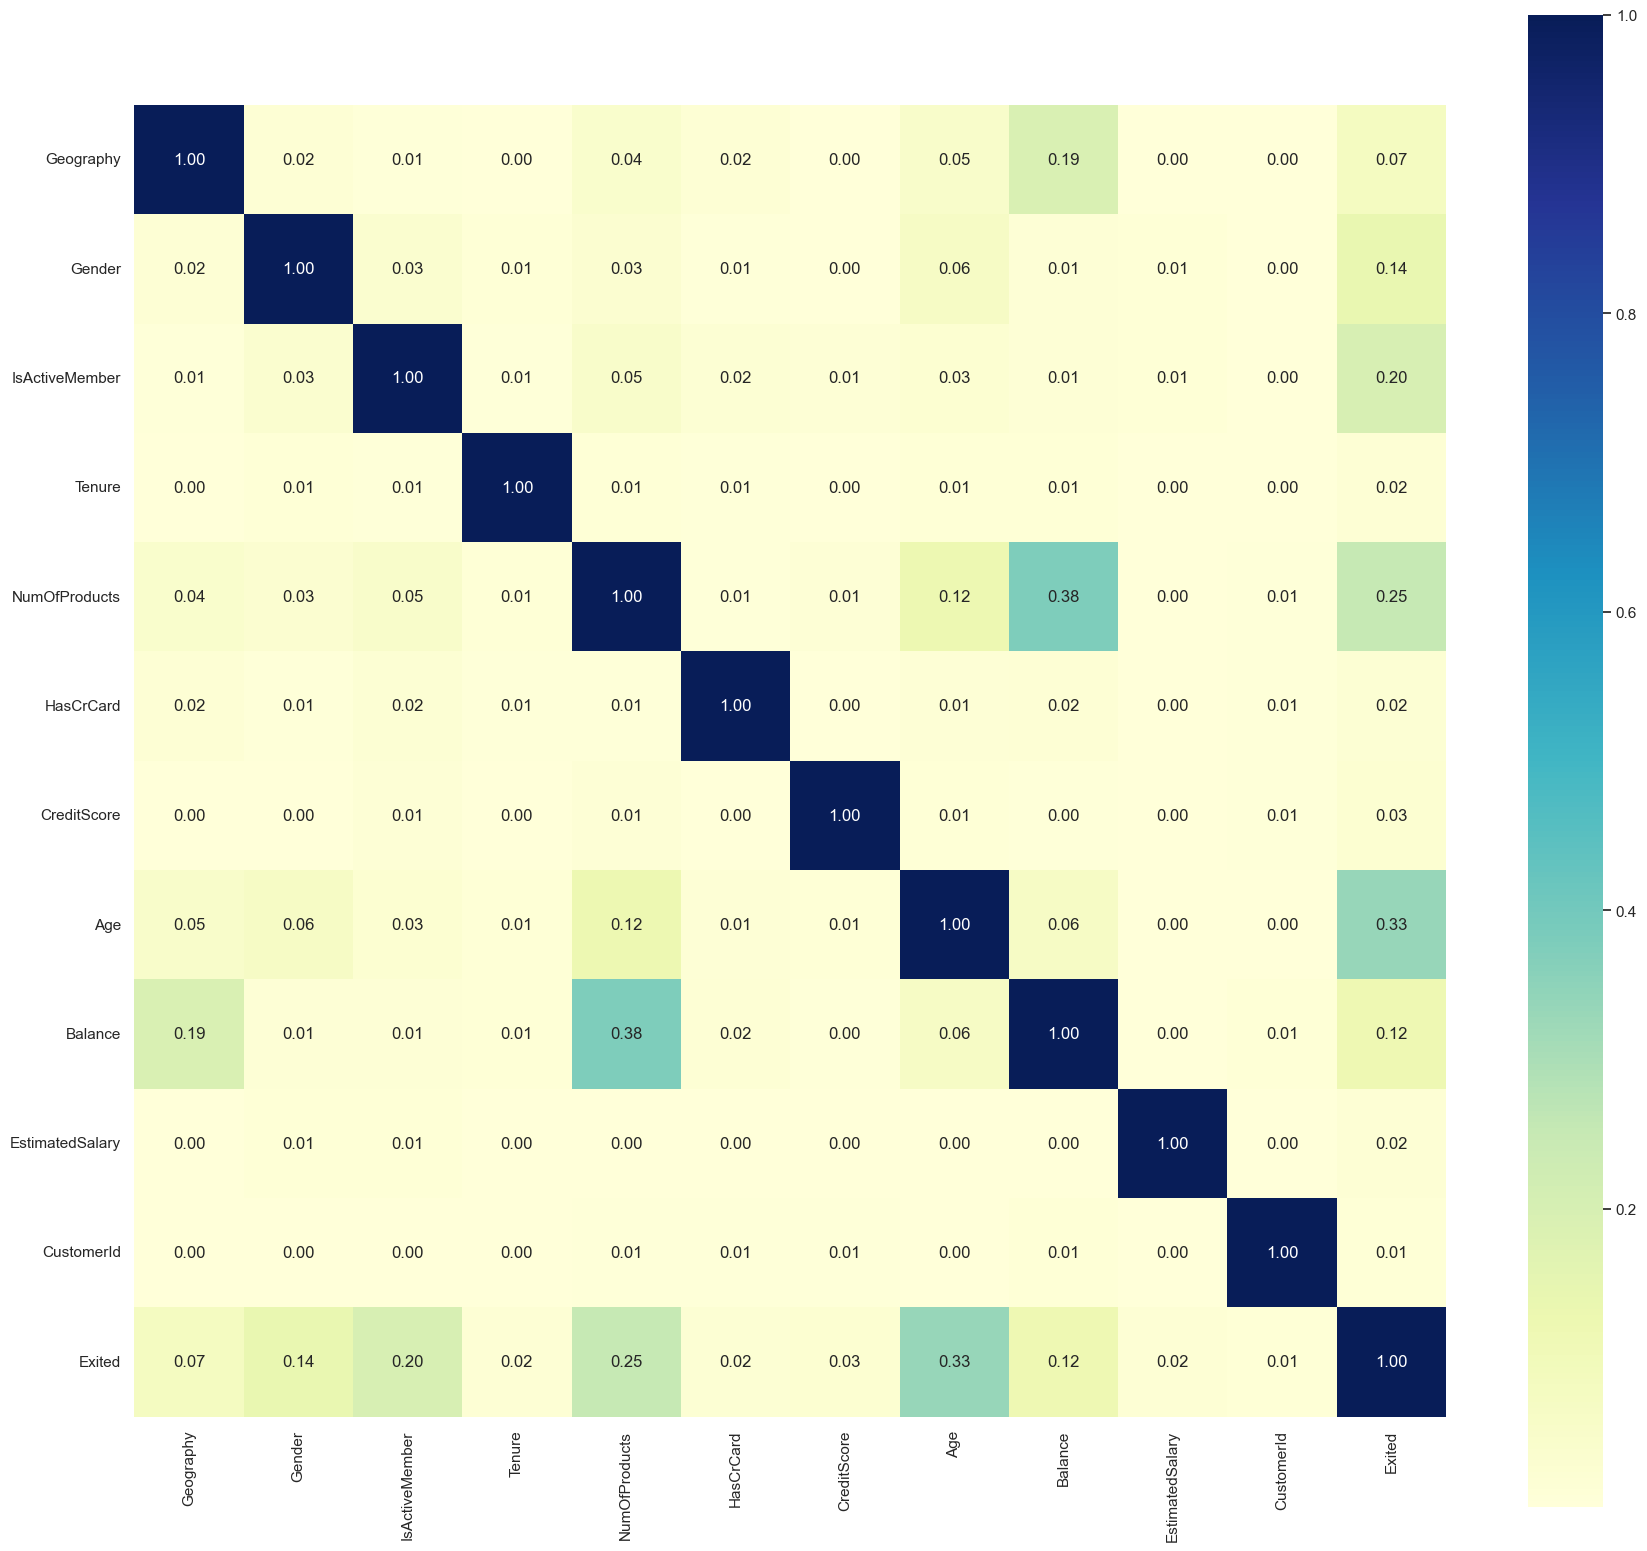

In [462]:
pipeline_all = Pipeline([
    ('encoder', label_encoding),
    ])

train_df_all = pipeline_all.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])
num_cols_ = train_df_all.select_dtypes(include=[np.number]).columns.tolist()
train_df_all = train_df_all[num_cols_]
train_df_all['Exited'] = train_df['Exited'].reset_index(drop=True)

corr_matrix = train_df_all.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(18, 16))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax, annot=True, fmt=".2f")

# Tight layout
f.tight_layout()

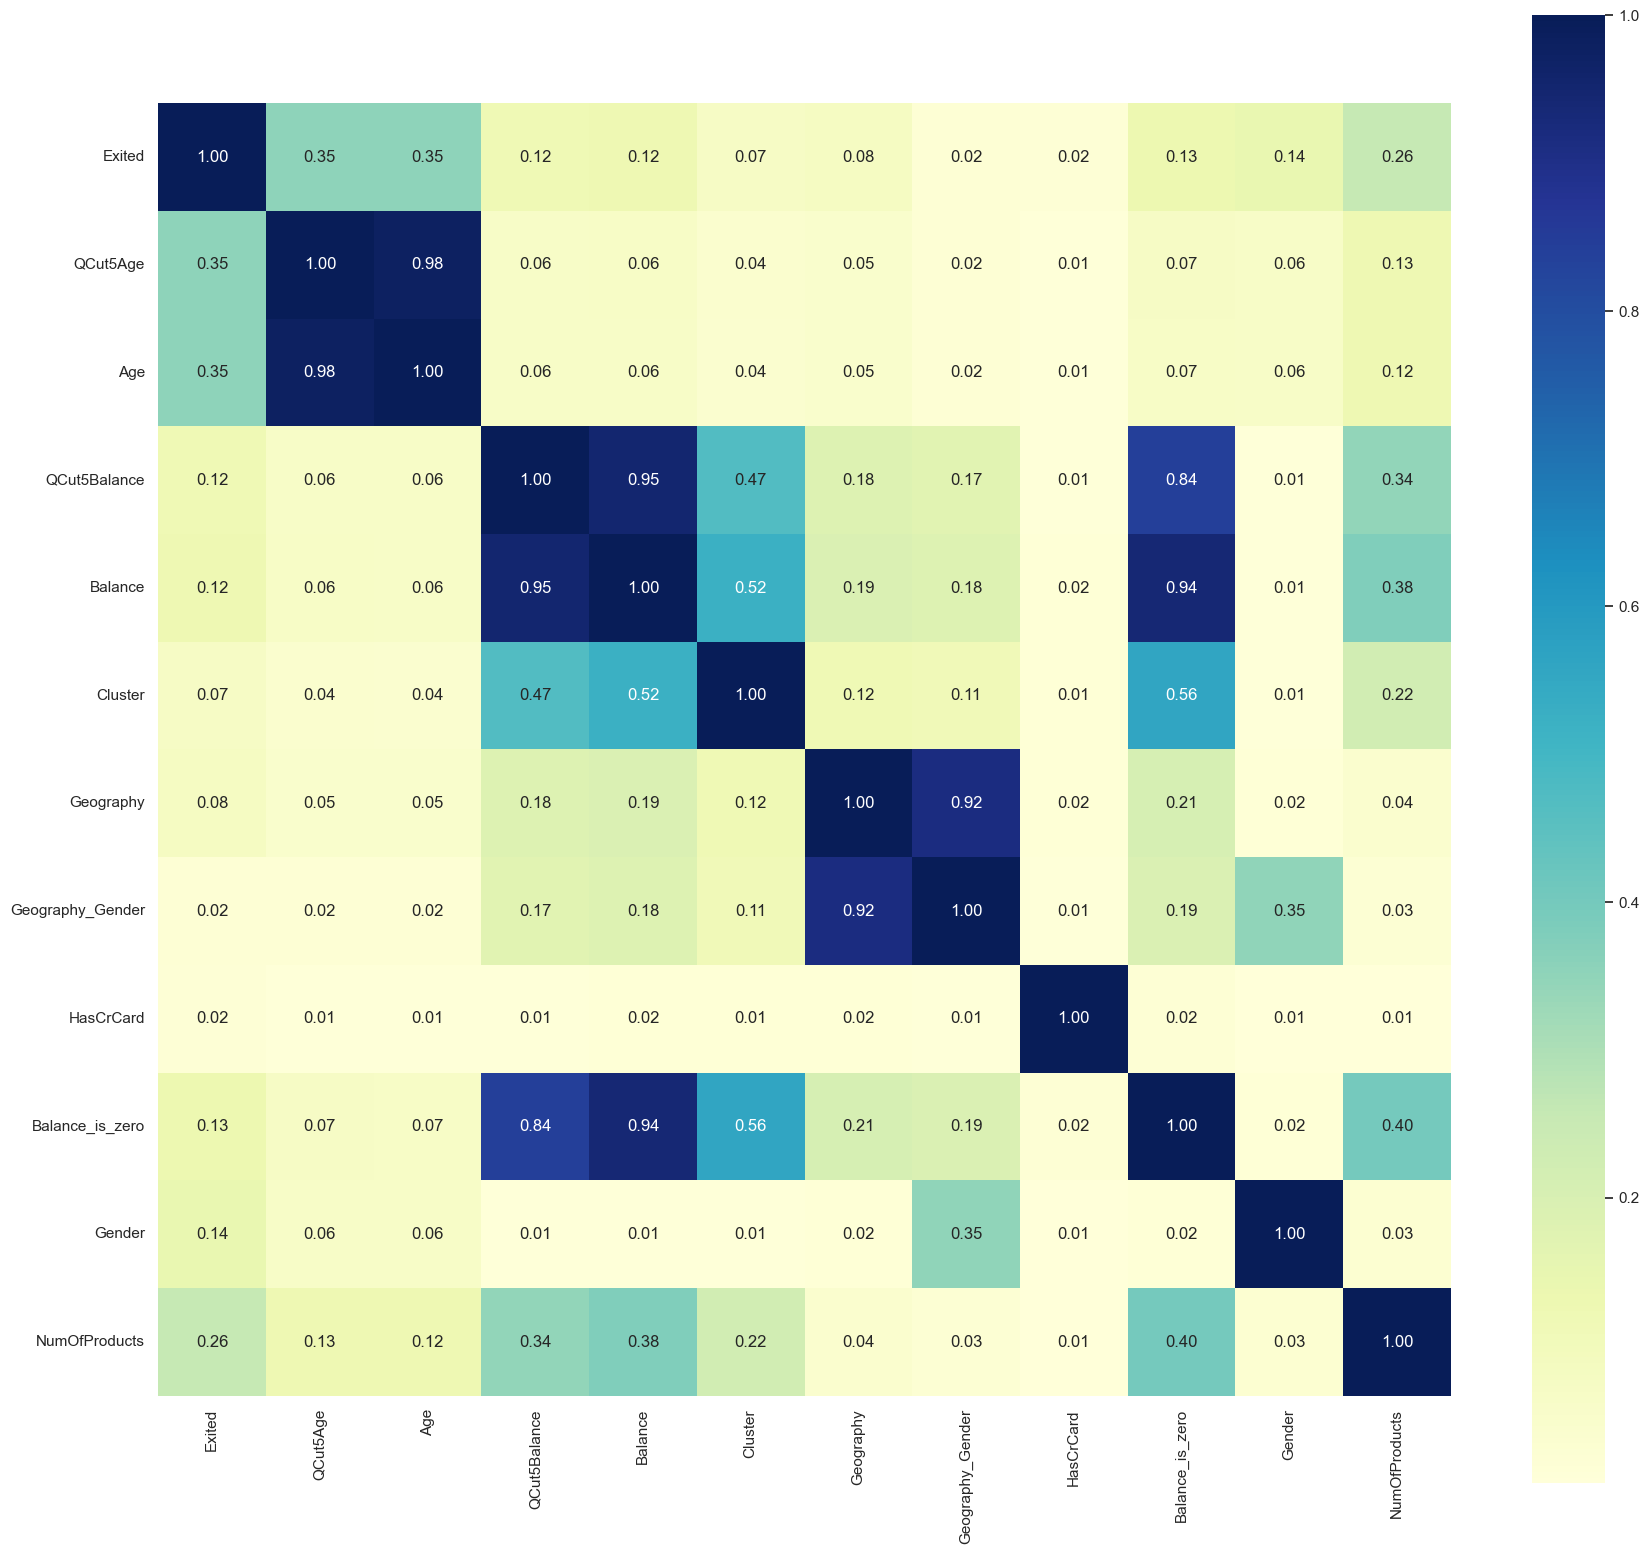

In [463]:
pipeline_all_sel = Pipeline([
    ('agg_balance_sum', agg_balance_sum),
    ('geo_gender', geo_gender),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('balance_binner', balance_binner),
    ('salary_binner', salary_binner),
    ('credit_score_binner', credit_score_binner),
    ('pca_cluster', pca_clustering_transformer),
    ('encoder', label_encoding),
    ('skb', feature_selector)
    ])

train_df_sel = pipeline_all_sel.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])
num_cols_ = train_df_sel.select_dtypes(include=[np.number]).columns.tolist()
train_df_sel = train_df_sel[num_cols_]
train_df_sel['Exited'] = train_df['Exited'].reset_index(drop=True)

corrmat = train_df_sel.corr()
cols = corrmat.nlargest(12, 'Exited')['Exited'].index

corr_matrix = train_df_sel[cols].corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(18, 16))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax, annot=True, fmt=".2f")

# Tight layout
f.tight_layout()

In [465]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Nothing to do here, return the transformer
        return self

    def transform(self, X):
        # Check if the input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # Drop the specified columns
        return X.drop(columns=self.columns, errors='ignore')

columnDrop = ColumnDropper(['CustomerID'])

In [466]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep):
        self.columns_to_keep = columns_to_keep

    def fit(self, X, y=None):
        # Nothing to do here, return the transformer
        return self

    def transform(self, X):
        # Check if the input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # Select only the specified columns
        return X[self.columns_to_keep]

selected_cols = ['QCut5Age',
'Age',
'PCA_1',
'Balance',
'Cluster',
'HasCrCard',
'Balance_is_zero',
'Geography_Gender',
'NumOfProducts']

columnSelect = ColumnSelector(selected_cols)

## 8. Model setup with pre-defined params

In [467]:
best_params_xgb = {'learning_rate': 0.09701089516649843, 
                   'max_depth': 5, 
                   'subsample': 0.8313883081132282}

best_params_lgbm = {'learning_rate': 0.09662854057910783, 
                    'max_depth': 5, 
                    'subsample': 0.958627306360428,}

best_params_hist = {'learning_rate': 0.0713352287172605, 
                    'max_iter': 603, 
                    'max_leaf_nodes': 36}

best_params_cat = {}

xgboost_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm, verbose=0)
hist_model = HistGradientBoostingClassifier(**best_params_hist)
cat_model = CatBoostClassifier(**best_params_cat)

## 9. Pipeline setup

In [468]:
pipeline_all_sel = Pipeline([
    ('geo_gender', geo_gender),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('pca_cluster', pca_clustering_transformer),
    #('selector', columnSelect),
    ('drop', columnDrop),
    ('encoder', encoding),
    ])


selected_pipeline = pipeline_all_sel
selected_pipeline

Pipeline(steps=[('geo_gender',
                 StringConcatenator(col1='Geography', col2='Gender')),
                ('balance_zero_transformer', ZeroTransformer(column='Balance')),
                ('age_binning', Binning(col='Age', n_bins=5)),
                ('pca_cluster',
                 PCAClusteringTransformer(columns=['CustomerId',
                                                   'EstimatedSalary',
                                                   'Balance'],
                                          n_clusters=3, n_components=2)),
                ('drop', ColumnDropper(columns=['CustomerID'])),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2c0328810>)]))])

In [469]:
xgboost_pipeline = make_pipeline(selected_pipeline, xgboost_model)

lgbm_pipeline = make_pipeline(selected_pipeline, lgbm_model)

hist_pipeline = make_pipeline(selected_pipeline, hist_model)

cat_pipeline = make_pipeline(selected_pipeline, cat_model)

In [470]:
def log_results(pipeline, params, cv, model):
    steps = [step[0] for step in pipeline.named_steps['pipeline'].steps]
    steps = ', '.join(steps)
    log_df = pd.DataFrame()
    log_df['Time'] = [datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')]
    log_df['Pipeline'] = [steps]
    log_df['Params'] = [params]
    log_df['ROC AUC'] = [cv]
    log_df['Model'] = [model]

    if os.path.exists('log.csv'):
        log_df_ = pd.read_csv('log.csv')
        log_df = pd.concat([log_df_, log_df])
        log_df.to_csv('log.csv', index=False)
    else:
        log_df.to_csv('log.csv', index=False)

## 10. Training

### 10.1 Hyperparam tuning with Optuna

In [471]:

def instantiate_xgboost(trial : Trial) -> XGBClassifier:
  params = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000, step=10),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        "min_child_weight": trial.suggest_int('min_child_weight', 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
  }
  return XGBClassifier(**params)

def instantiate_lgbm(trial : Trial) -> LGBMClassifier:
  params = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000, step=10),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int('min_child_samples', 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
  }
  return LGBMClassifier(**params)

def instantiate_hist(trial: Trial) -> HistGradientBoostingClassifier:
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 64),
    }
    return HistGradientBoostingClassifier(**params)

def instantiate_cat(trial: Trial) -> CatBoostClassifier:
    params = {
        "iterations": trial.suggest_int('iterations', 50, 1000, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 1)
    }
    return CatBoostClassifier(**params)

In [472]:
def objective(trial : Trial, pipeline, X, y ,algo):
    
    if algo == 'xgb':
        # XGBOOST
        # pipeline = make_pipeline(pipeline, instantiate_xgboost(trial))
        model = instantiate_xgboost(trial)
    elif algo == 'lgbm':
        # LGBM
        # pipeline = make_pipeline(pipeline, instantiate_lgbm(trial))
        model = instantiate_lgbm(trial)
    elif algo == 'hist':
        #pipeline = make_pipeline(pipeline, instantiate_hist(trial))
        model = instantiate_hist(trial)
    elif algo == 'cat':
        model = instantiate_cat(trial)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=skf)
  
    return np.min([np.mean(scores), np.median([scores])])

In [477]:
transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

study_xgb = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study_xgb.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'xgb'), n_trials=200)

[I 2024-01-21 20:34:30,940] A new study created in memory with name: optimization
[I 2024-01-21 20:35:19,959] Trial 0 finished with value: 0.8797486015406835 and parameters: {'n_estimators': 440, 'learning_rate': 0.031057471724412082, 'min_child_weight': 1, 'max_depth': 12}. Best is trial 0 with value: 0.8797486015406835.
[I 2024-01-21 20:35:37,160] Trial 1 finished with value: 0.8766957285724511 and parameters: {'n_estimators': 170, 'learning_rate': 0.1031649315594684, 'min_child_weight': 7, 'max_depth': 15}. Best is trial 0 with value: 0.8797486015406835.
[I 2024-01-21 20:36:03,849] Trial 2 finished with value: 0.8870717452695864 and parameters: {'n_estimators': 710, 'learning_rate': 0.050767344468596876, 'min_child_weight': 1, 'max_depth': 6}. Best is trial 2 with value: 0.8870717452695864.
[I 2024-01-21 20:36:42,194] Trial 3 finished with value: 0.8806480905846841 and parameters: {'n_estimators': 960, 'learning_rate': 0.08010028571745326, 'min_child_weight': 8, 'max_depth': 8}. Bes

In [ ]:
transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

study_lgbm = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study_lgbm.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'lgbm'), n_trials=200)

[I 2024-01-21 20:23:06,807] A new study created in memory with name: optimization


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you

[W 2024-01-21 20:23:11,581] Trial 0 failed with parameters: {'n_estimators': 930, 'learning_rate': 0.05899305088194977, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9989022327071795} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/krystianpietrzak/Documents/ML/Kaggle/Kaggle-S4E1/.conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/1887253026.py", line 5, in <lambda>
    study_lgbm.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'lgbm'), n_trials=200)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/2359589805.py", line 19, in objective
    scores = cross_val_sco

KeyboardInterrupt: 

In [ ]:
# transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

# study_hist = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

# study_hist.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'hist'), n_trials=200)

[I 2024-01-19 12:43:20,126] A new study created in memory with name: optimization
[I 2024-01-19 12:44:04,105] Trial 0 finished with value: 0.8877351009382023 and parameters: {'learning_rate': 0.07474837880377516, 'max_iter': 733, 'max_leaf_nodes': 59}. Best is trial 0 with value: 0.8877351009382023.
[I 2024-01-19 12:44:24,618] Trial 1 finished with value: 0.8877702119568825 and parameters: {'learning_rate': 0.13508140895103604, 'max_iter': 160, 'max_leaf_nodes': 44}. Best is trial 1 with value: 0.8877702119568825.
[I 2024-01-19 12:44:39,199] Trial 2 finished with value: 0.887489915185088 and parameters: {'learning_rate': 0.1833038442707651, 'max_iter': 704, 'max_leaf_nodes': 39}. Best is trial 1 with value: 0.8877702119568825.
[I 2024-01-19 12:44:48,678] Trial 3 finished with value: 0.8871995148365922 and parameters: {'learning_rate': 0.2944309953612552, 'max_iter': 530, 'max_leaf_nodes': 33}. Best is trial 1 with value: 0.8877702119568825.
[I 2024-01-19 12:45:02,533] Trial 4 finished 

KeyboardInterrupt: 

In [ ]:
transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

study_cat = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study_cat.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'cat'), n_trials=200)

[I 2024-01-21 20:23:15,257] A new study created in memory with name: optimization


0:	learn: 0.6191587	total: 25.1ms	remaining: 24.6s
1:	learn: 0.5605423	total: 36.6ms	remaining: 17.9s
2:	learn: 0.5162043	total: 48.7ms	remaining: 15.8s
3:	learn: 0.4790693	total: 61ms	remaining: 14.9s
4:	learn: 0.4517318	total: 70.9ms	remaining: 13.8s
5:	learn: 0.4281777	total: 82.8ms	remaining: 13.4s
6:	learn: 0.4098038	total: 94ms	remaining: 13.1s
7:	learn: 0.3950470	total: 106ms	remaining: 12.8s
8:	learn: 0.3827544	total: 117ms	remaining: 12.6s
9:	learn: 0.3729603	total: 128ms	remaining: 12.4s
10:	learn: 0.3648762	total: 139ms	remaining: 12.3s
11:	learn: 0.3583932	total: 149ms	remaining: 12.1s
12:	learn: 0.3529683	total: 161ms	remaining: 12s
13:	learn: 0.3486073	total: 172ms	remaining: 11.9s
14:	learn: 0.3448833	total: 183ms	remaining: 11.8s
15:	learn: 0.3418081	total: 193ms	remaining: 11.6s
16:	learn: 0.3394412	total: 203ms	remaining: 11.5s
17:	learn: 0.3374069	total: 215ms	remaining: 11.5s
18:	learn: 0.3354173	total: 226ms	remaining: 11.4s
19:	learn: 0.3337975	total: 237ms	remain

[W 2024-01-21 20:23:16,476] Trial 0 failed with parameters: {'iterations': 980, 'learning_rate': 0.0794667410910635, 'depth': 7, 'l2_leaf_reg': 0.005083185841213998} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/krystianpietrzak/Documents/ML/Kaggle/Kaggle-S4E1/.conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/3207316025.py", line 5, in <lambda>
    study_cat.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'cat'), n_trials=200)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/2359589805.py", line 19, in objective
    scores = cross_val_score(model, X, y, scoring=roc_auc

95:	learn: 0.3169744	total: 1.05s	remaining: 9.69s
96:	learn: 0.3169134	total: 1.06s	remaining: 9.68s
97:	learn: 0.3168535	total: 1.07s	remaining: 9.68s
98:	learn: 0.3167883	total: 1.08s	remaining: 9.66s
99:	learn: 0.3167219	total: 1.09s	remaining: 9.64s
100:	learn: 0.3166406	total: 1.1s	remaining: 9.62s
101:	learn: 0.3165576	total: 1.11s	remaining: 9.59s
102:	learn: 0.3165233	total: 1.12s	remaining: 9.57s


KeyboardInterrupt: 

In [ ]:
# XGBOOST
best_params = study_xgb.best_params
xgboost_model = XGBClassifier(**best_params, silent=True)
xgboost_pipeline = make_pipeline(selected_pipeline, xgboost_model)
average_cv_result = study_xgb.best_trial.values[0]
log_results(xgboost_pipeline, best_params, average_cv_result, 'xgboost')

# LGBM
best_params = study_lgbm.best_params
lgbm_model = LGBMClassifier(**best_params, silent=True)
lgbm_pipeline = make_pipeline(selected_pipeline, lgbm_model)
average_cv_result = study_lgbm.best_trial.values[0]
log_results(lgbm_pipeline, best_params, average_cv_result, 'lgbm')

# HIST
#best_params = study_hist.best_params
# best_params = {'learning_rate': 0.0713352287172605, 'max_iter': 603, 'max_leaf_nodes': 36}
# hist_model = HistGradientBoostingClassifier(**best_params)
# hist_pipeline = make_pipeline(selected_pipeline, hist_model)
# average_cv_result = study_hist.best_trial.values[0]
# log_results(hist_pipeline, best_params, average_cv_result, 'hist')

# CATBOOST
best_params = study_cat.best_params
cat_model = CatBoostClassifier(**best_params)
cat_pipeline = make_pipeline(selected_pipeline, hist_model)
average_cv_result = study_cat.best_trial.values[0]
log_results(cat_pipeline, best_params, average_cv_result, 'cat')

ValueError: No trials are completed yet.

### 10.2 No Hyperparam tuning

In [ ]:
def crossval(pipeline, params):
    X = train_df[cat_cols+num_cols+['CustomerId']].reset_index(drop=True)
    y = train_df['Exited'].reset_index(drop=True)

    # number of folds
    n_splits = 10

    #  StratifiedKFold
    stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    #  cross-validation results
    cv_results = []

    # stratified k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        pipeline.fit(X_train, y_train)

        # predictions on the validation set
        y_val_pred_prob = pipeline.predict_proba(X_val)[:,1]
            
        # Evaluating the model
        roc_auc = roc_auc_score(y_val, y_val_pred_prob)
        print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
        print('-'*70)

        # results
        cv_results.append(roc_auc)

    # average cross-validation result
    average_cv_result = sum(cv_results) / n_splits
    print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')
    log_results(pipeline, params, average_cv_result, 'catboost')

In [ ]:
# crossval(xgboost_pipeline, best_params_xgb)
# crossval(lgbm_pipeline, best_params_lgbm)
# crossval(hist_pipeline, best_params_hist)
# crossval(cat_pipeline, best_params_cat)

Fold 1, AUC Score on Validation Set: 0.8741951600145219
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.875433374623156
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.8719129209871471
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.8733588301561068
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.8746762241343794
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.8745830644754198
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.8708951549765993
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.8729882001161968
--------------------------------------------------------

## 11. Result Evaluation

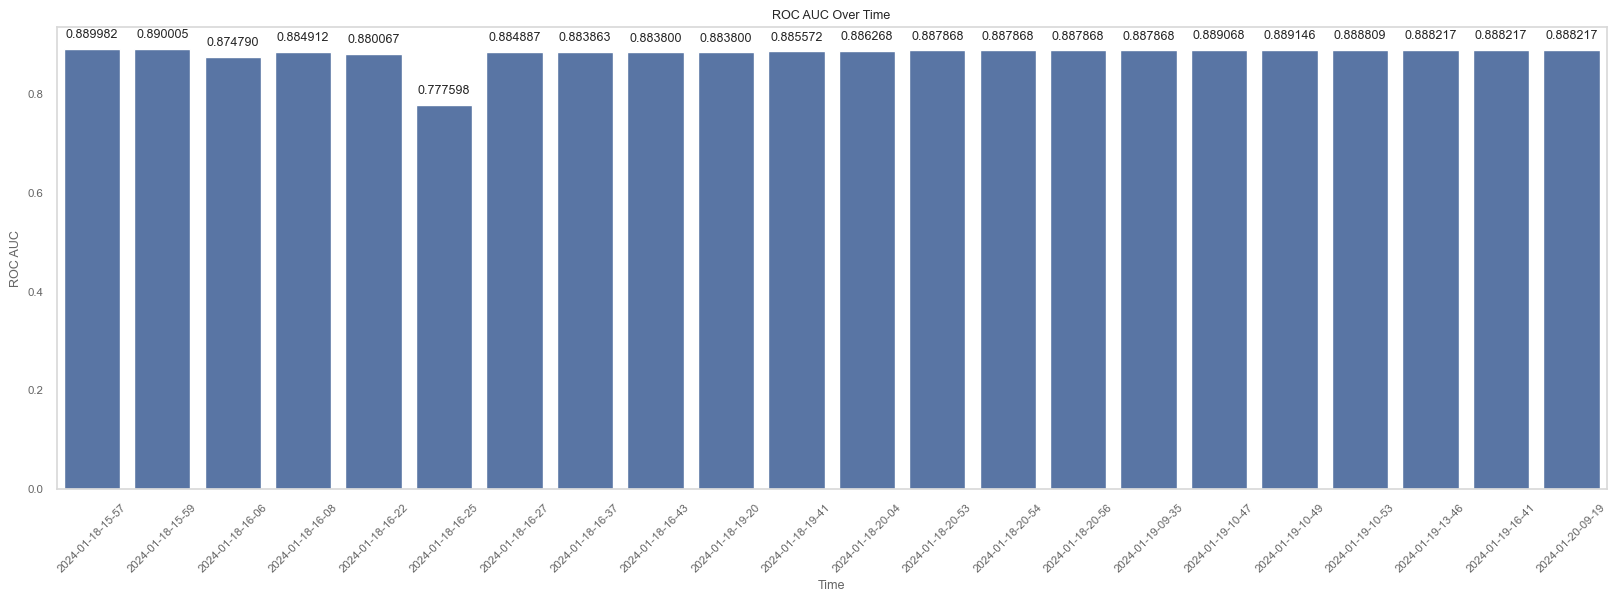

----------------------------------------------------------------------
encoder
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8899819036038054
----------------------------------------------------------------------
age_binning, encoder
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8900045215754551
----------------------------------------------------------------------
age_binning, encoder, scaler, skb
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8747904837669018
----------------------------------------------------------------------
age_binning, encoder, skb
 catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.4

In [ ]:
# df_log = pd.read_csv('log.csv')
# plt.figure(figsize=(20, 6))
# ax = sns.barplot(data=df_log, x='Time', y='ROC AUC')
# plt.xticks(rotation=45)
# plt.title('ROC AUC Over Time')
# plt.xlabel('Time')
# plt.ylabel('ROC AUC')

# # Adding the text on the bars
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.6f'), 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha = 'center', va = 'center', 
#                 xytext = (0, 10), 
#                 textcoords = 'offset points')

# plt.show()

# for param, pipeline, model, score  in zip(df_log['Params'], df_log['Pipeline'], df_log['Model'], df_log['ROC AUC']):
#     print('-'*70)
#     print(pipeline)
#     print(model)
#     print(param)
#     print(score)

## 12. Ensemble

### 12.1 Hyperparameter tuning of weights for ensemble

In [ ]:
def objective(trial: Trial, xgboost_pipeline, lgbm_pipeline, cat_pipeline):
    X = train_df[cat_cols+num_cols+['CustomerId']]
    y = train_df['Exited']

    # Suggest weights for the ensemble components
    weight_xgb = trial.suggest_float('xgb_weight', 0.1, 1)
    weight_lgbm = trial.suggest_float('lgbm_weight', 0.1, 1)
    weight_cat = trial.suggest_float('hist_weight', 0.1, 1)

    # Create the ensemble model with the suggested weights
    ensemble_model = VotingClassifier(
        estimators=[
            ('xgb', xgboost_pipeline),
            ('lgbm', lgbm_pipeline),
            ('cat', cat_pipeline),
        ],
        voting='soft',
        weights=[weight_xgb, weight_lgbm, weight_cat]
    )

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(ensemble_model, X, y, scoring=roc_auc_scorer, cv=skf)

    # Return the mean of the ROC AUC scores
    return np.mean(scores)

In [ ]:
study_ensemble = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_ensemble.optimize(lambda trial: objective(trial, xgboost_pipeline, lgbm_pipeline, cat_pipeline), n_trials=10)

[I 2024-01-21 19:56:26,621] A new study created in memory with name: no-name-36d3ea66-8491-4730-897b-082c3ac5c7e8


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-01-21 19:57:09,817] Trial 0 finished with value: 0.8741148674433115 and parameters: {'xgb_weight': 0.9093325349494419, 'lgbm_weight': 0.7576039585288772, 'hist_weight': 0.30163262976458066}. Best is trial 0 with value: 0.8741148674433115.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-01-21 19:57:53,453] Trial 1 finished with value: 0.8741490849010853 and parameters: {'xgb_weight': 0.11254682109724935, 'lgbm_weight': 0.5807706855891775, 'hist_weight': 0.2669565326358224}. Best is trial 1 with value: 0.8741490849010853.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-01-21 19:58:37,174] Trial 2 finished with value: 0.8741076405172382 and parameters: {'xgb_weight': 0.4008603267497118, 'lgbm_weight': 0.5389778466640085, 'hist_weight': 0.2710070463405461}. Best is trial 1 with value: 0.8741490849010853.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[W 2024-01-21 19:59:08,052] Trial 3 failed with parameters: {'xgb_weight': 0.7244228700884541, 'lgbm_weight': 0.5455810157894029, 'hist_weight': 0.5245464374608928} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/krystianpietrzak/Documents/ML/Kaggle/Kaggle-S4E1/.conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/1934351666.py", line 2, in <lambda>
    study_ensemble.optimize(lambda trial: objective(trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline), n_trials=10)
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/773533221.py", line 24, in objective
    scores = cross_val_score(ensemble_model, X, y, scoring=roc_auc_scorer, cv=sk

KeyboardInterrupt: 

In [ ]:
best_params_ensemble = {'xgb_weight': 0.9476128707220737, 'lgbm_weight': 0.5626673694518467, 'cat_weight': 0.23987315205853274}
ensemble_model = VotingClassifier(estimators=[
                                                ('xgb', xgboost_pipeline),
                                                ('lgbm', lgbm_pipeline),
                                                ('cat', cat_pipeline),
                                             ], voting='soft', weights = [best_params_ensemble['xgb_weight'], best_params_ensemble['lgbm_weight'], best_params_ensemble['cat_weight']]) 

## Pseudo Labels

In [ ]:
if CFG.use_pseudo:
    ensemble_model.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
    test_preds = ensemble_model.predict(test_df[cat_cols + num_cols+['CustomerId']])

    test_df['predictions'] = test_preds
    test_df.head()

    cutoff = 0.95 # Probability CutOff...
    pseudo_set_1 = test_df[test_df['predictions'] > cutoff]
    pseudo_set_1['Exited'] = 1
    pseudo_set_1.drop(columns=['predictions'], axis = 1, inplace=True)

    pseudo_set_2 = test_df[test_df['predictions'] < 1 - cutoff]
    pseudo_set_2['Exited'] = 0
    pseudo_set_2.drop(columns=['predictions'], axis = 1, inplace=True)

    pseudo_set = pd.concat([pseudo_set_1,pseudo_set_2])
    
    pseudo_train_df = pd.concat([train_df, pseudo_set])
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(ensemble_model, pseudo_train_df[cat_cols + num_cols+['CustomerId']], pseudo_train_df['Exited'], scoring=roc_auc_scorer, cv=skf)
    print(f'ROC-AUC: {np.min([np.mean(scores), np.median([scores])])}')

    ensemble_model.fit(pseudo_train_df[cat_cols + num_cols+['CustomerId']], pseudo_train_df['Exited'])
    test_probabilities = ensemble_model.predict_proba(test_df[cat_cols + num_cols + ['CustomerId']])[:,1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36959, number of negative: 138073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 175032, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317973
[LightGBM] [Info] Start training from score -1.317973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

(110023, 13)

## SHAP

### XGBoost

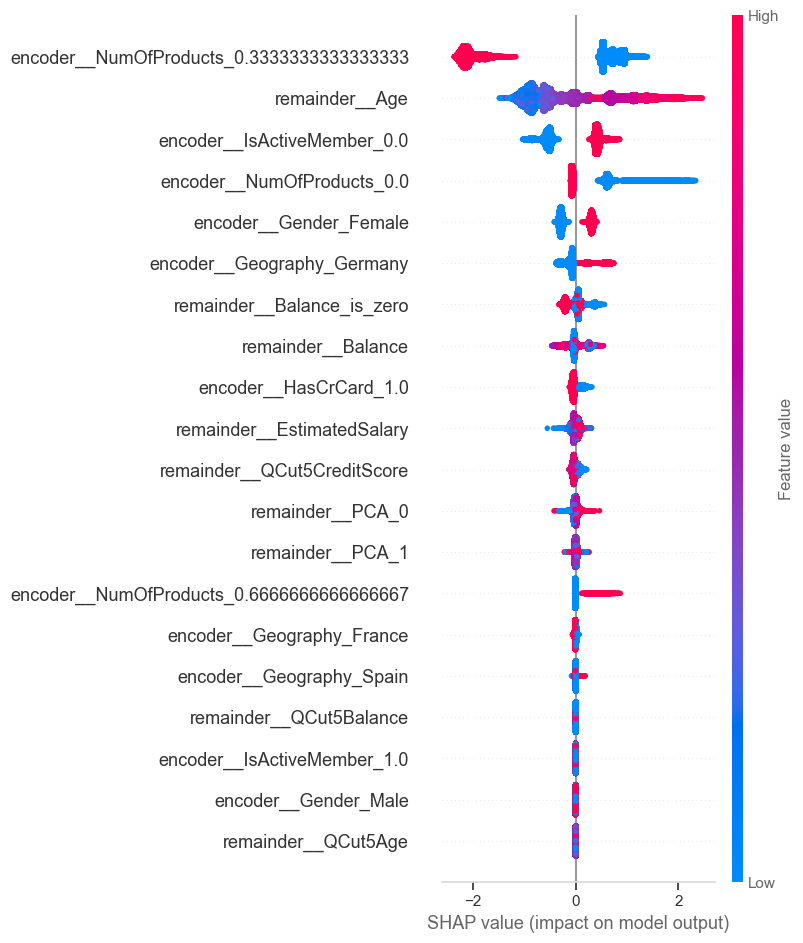

In [ ]:
# model = ensemble_model.named_estimators['xgb'][1]
# train_df_transformed = selected_pipeline.fit_transform(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
# test_df_transformed = selected_pipeline.transform(test_df[cat_cols + num_cols + ['CustomerId']])
# model.fit(train_df_transformed, train_df['Exited'])
# explainer = shap.TreeExplainer(model)

# shap_values = explainer.shap_values(test_df_transformed)
# shap.summary_plot(shap_values, test_df_transformed)

### LGBM

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36959, number of negative: 138073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 175032, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317973
[LightGBM] [Info] Start training from score -1.317973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

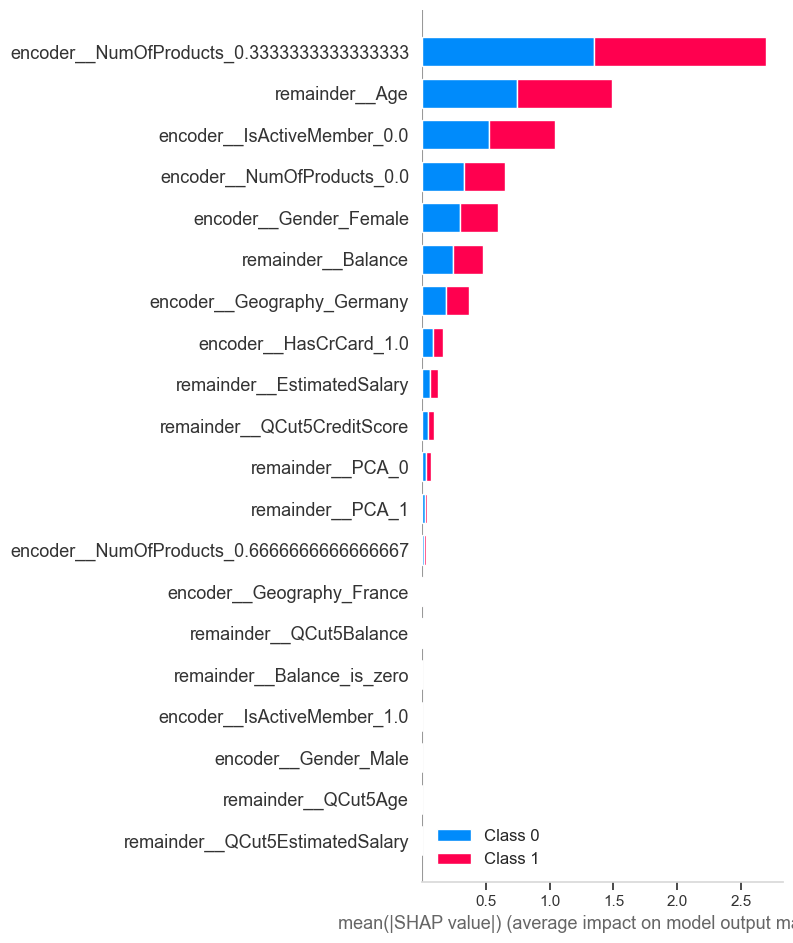

In [ ]:
# model = ensemble_model.named_estimators['lgbm'][1]
# train_df_transformed = selected_pipeline.fit_transform(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
# test_df_transformed = selected_pipeline.transform(test_df[cat_cols + num_cols + ['CustomerId']])
# model.fit(train_df_transformed, train_df['Exited'])
# explainer = shap.TreeExplainer(model)

# shap_values = explainer.shap_values(test_df_transformed)
# shap.summary_plot(shap_values, test_df_transformed)

### Hist

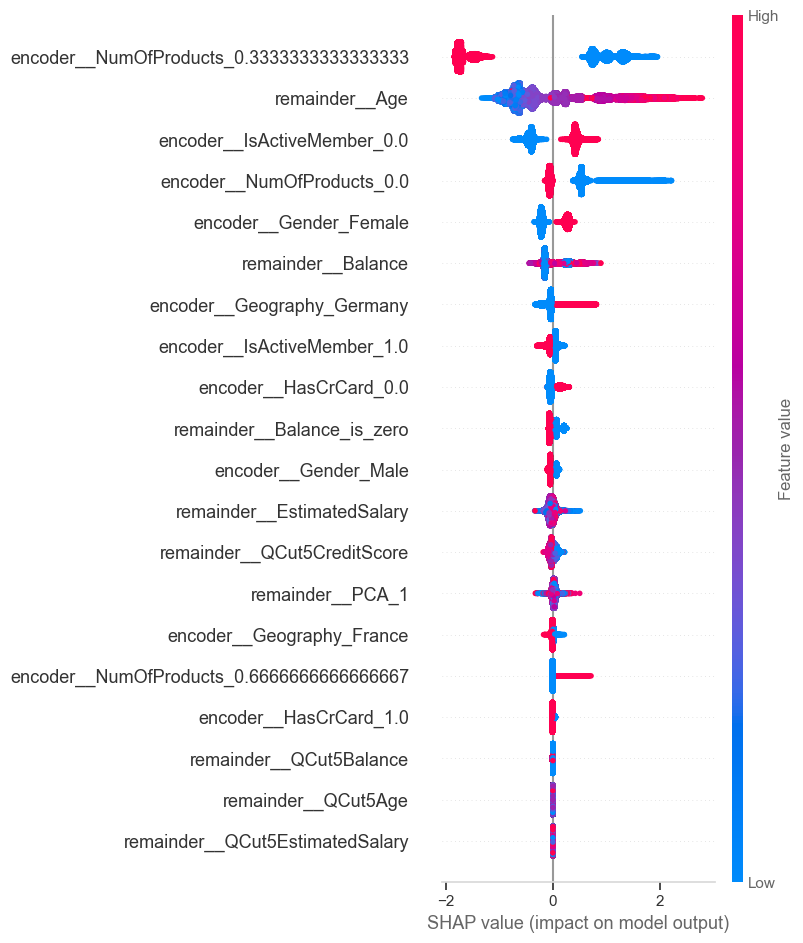

In [ ]:
# model = ensemble_model.named_estimators['hist'][1]
# train_df_transformed = selected_pipeline.fit_transform(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
# test_df_transformed = selected_pipeline.transform(test_df[cat_cols + num_cols + ['CustomerId']])
# model.fit(train_df_transformed, train_df['Exited'])
# explainer = shap.TreeExplainer(model)

# shap_values = explainer.shap_values(test_df_transformed)
# shap.summary_plot(shap_values, test_df_transformed)

## Submission

In [ ]:
ensemble_model.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
test_probabilities = ensemble_model.predict_proba(test_df[cat_cols + num_cols+['CustomerId']])[:,1]

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36959, number of negative: 138073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 175032, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317973
[LightGBM] [Info] Start training from score -1.317973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['Exited'] = test_probabilities
sub = sub.set_index('id')
sub.head()

,Exited
id,
165034,0.03
165035,0.79
165036,0.03
165037,0.23
165038,0.38


In [ ]:
sub.to_csv('submission.csv')